# Задача

Прогнозирование продаж каждого SKU (артикул) с целью формирования оптимального заказа на год вперед на базе параметра "покрытие" (кол-во месяцев до полного истощения стока)

### 1. загружаем необходимые пакеты

In [99]:
import pandas as pd
import numpy as np
import tqdm
import random
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

### 2. загружаем данные продаж

In [101]:
df = pd.read_csv("bottles.csv", sep = ";", encoding = "latin")

In [102]:
df

,Wine.Denom.True,Year,Month,bottles
0,00100114 /,2017,1,1
1,00100224 /,2017,1,0
2,00100324 /,2017,1,7
3,00100424 /,2017,1,4
4,00100524 /,2017,1,3
...,...,...,...,...
170619,90500814 /,2022,4,55
170620,90500924 /,2022,4,8
170621,90501014 /,2022,4,8
170622,90600124 /,2022,4,0


In [103]:
df.rename(columns = {'Unnamed: 0': 'num', 'V1': 'bottles', 'Wine.Denom.True': 'Wine_Denom'}, inplace = True)

In [104]:
df.tail()

,Wine_Denom,Year,Month,bottles
170619,90500814 /,2022,4,55
170620,90500924 /,2022,4,8
170621,90501014 /,2022,4,8
170622,90600124 /,2022,4,0
170623,90600214 /,2022,4,0


### 3. формируем список со всеми SKU:

In [105]:
wines = df['Wine_Denom'].unique()

In [106]:
import datetime as dt

### 4. преобразовываем колонку с датой

In [107]:
df['date'] = df.apply(lambda x: str(round(x.Year)) + '-' + str(round(x.Month)) + '-' + str(1), axis=1)

In [108]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')

In [109]:
df.tail()

,Wine_Denom,Year,Month,bottles,date
170619,90500814 /,2022,4,55,2022-04-01
170620,90500924 /,2022,4,8,2022-04-01
170621,90501014 /,2022,4,8,2022-04-01
170622,90600124 /,2022,4,0,2022-04-01
170623,90600214 /,2022,4,0,2022-04-01


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170624 entries, 0 to 170623
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Wine_Denom  170624 non-null  object        
 1   Year        170624 non-null  int64         
 2   Month       170624 non-null  int64         
 3   bottles     170624 non-null  int64         
 4   date        170624 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 6.5+ MB


### 5. Нормализируем продажи через метод CUSUM

In [111]:
wine = '08200514 /'
wine_series = df[df.Wine_Denom == wine]

In [112]:
calculations = pd.DataFrame(columns=list(['rolling_mean', 'st_dev', 'zscore', 'signal_low', 'alarm', 'normalized']), 
                            index=list(range(0,len(wine_series))))

In [113]:
for i in range(0, len(wine_series)):
    
    drift = 0.25
    
    if i == 0 or i == 1:
        
        calculations.loc[i]['rolling_mean'] = wine_series['bottles'].values[i]
        calculations.loc[i]['st_dev'] = wine_series['bottles'].values[i]
        
    elif i < 12:
        
        calculations.loc[i]['rolling_mean'] = wine_series['bottles'].rolling(window = i).mean().values[i]
        calculations.loc[i]['st_dev'] = wine_series['bottles'].rolling(window = i).std().values[i]
        
    else:
        
        calculations.loc[i]['rolling_mean'] = wine_series['bottles'].rolling(window = 12).mean().values[i]
        calculations.loc[i]['st_dev'] = wine_series['bottles'].rolling(window = i).std().values[i]
        
        
    calculations.loc[i]['zscore'] = ( wine_series['bottles'].values[i] - calculations.loc[i]['rolling_mean'] ) / calculations.loc[i]['st_dev']
    
    try:
        calculations.loc[i]['signal_low'] = max(0,calculations.loc[i-1]['signal_low'] - calculations.loc[i]['zscore'] - drift)
    except:    
        calculations.loc[i]['signal_low'] = 0
    
    if calculations.loc[i]['signal_low'] > 1:
        calculations.loc[i]['alarm'] = 1
    else:
        calculations.loc[i]['alarm'] = 0
    
    
    if calculations.loc[i]['alarm'] == 1:
        calculations.loc[i]['normalized'] = random.uniform(calculations.loc[i]['rolling_mean'] - calculations.loc[i]['st_dev']*drift, 
                                                           calculations.loc[i]['rolling_mean'] + calculations.loc[i]['st_dev']*drift)
    else:
        calculations.loc[i]['normalized'] = wine_series['bottles'].values[i]

In [114]:
calculations.head(15)

,rolling_mean,st_dev,zscore,signal_low,alarm,normalized
0,38,38,0,0,0,38
1,102,102,0,0,0,102
2,95.5,9.19239,-0.707107,0.457107,0,89
3,94.6667,6.65833,-0.250313,0.45742,0,93
4,100.25,12.4197,1.34866,0,0,117
5,112.4,29.2199,1.66325,0,0,161
6,126.667,43.6379,1.63466,0,0,198
7,148.286,69.7035,1.86094,0,0,278
8,144.5,65.4152,-0.405105,0.155105,0,118
9,140.889,62.1419,-0.464886,0.369991,0,112


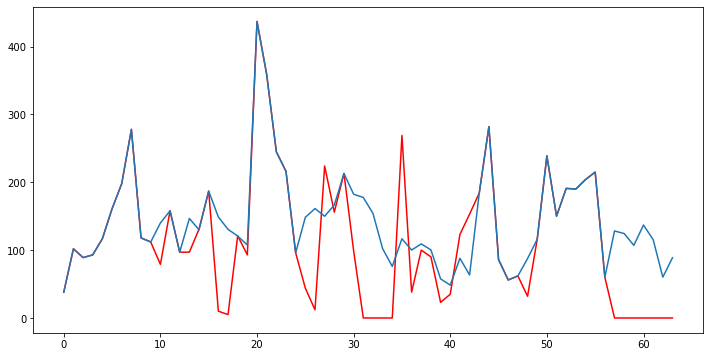

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(df[df.Wine_Denom == wine]['bottles'].values, "r")
plt.plot(calculations['normalized'])

In [18]:
df.loc[df['Wine_Denom'] == wine, ['bottles']] = calculations['normalized'].values

In [19]:
df[df.Wine_Denom == wine].tail(15)

,Wine_Denom,Year,Month,bottles,date
131702,08200514 /,2021,2,116,2021-02-01
134368,08200514 /,2021,3,239,2021-03-01
137034,08200514 /,2021,4,150,2021-04-01
139700,08200514 /,2021,5,191,2021-05-01
142366,08200514 /,2021,6,190,2021-06-01
145032,08200514 /,2021,7,204,2021-07-01
147698,08200514 /,2021,8,215,2021-08-01
150364,08200514 /,2021,9,60,2021-09-01
153030,08200514 /,2021,10,136.527,2021-10-01
155696,08200514 /,2021,11,123.666,2021-11-01


In [20]:
for wine in wines:
    NM_value = str(wine)
    #print(NM_value)
    wine_series = df[df.Wine_Denom == wine]
    
    calculations = pd.DataFrame(columns=list(['rolling_mean', 'st_dev', 'zscore', 'signal_low', 'alarm', 'normalized']), 
                            index=list(range(0,len(wine_series))))
    
    for i in range(0, len(wine_series)):
    
        drift = 0.25
    
        if i == 0 or i == 1:
        
            calculations.loc[i]['rolling_mean'] = wine_series['bottles'].values[i]
            calculations.loc[i]['st_dev'] = wine_series['bottles'].values[i]
        
        elif i < 12:
        
            calculations.loc[i]['rolling_mean'] = wine_series['bottles'].rolling(window = i).mean().values[i]
            
        else:
        
            calculations.loc[i]['rolling_mean'] = wine_series['bottles'].rolling(window = 12).mean().values[i]
        
        try:
            calculations.loc[i]['st_dev'] = wine_series['bottles'].rolling(window = i).std().values[i]
        except:
            calculations.loc[i]['st_dev'] = wine_series['bottles'].rolling(window = i).mean().values[i]
        
        calculations.loc[i]['zscore'] = ( wine_series['bottles'].values[i] - calculations.loc[i]['rolling_mean'] ) / calculations.loc[i]['st_dev']
    
        try:
            calculations.loc[i]['signal_low'] = max(0,calculations.loc[i-1]['signal_low'] - calculations.loc[i]['zscore'] - drift)
        except:    
            calculations.loc[i]['signal_low'] = 0
    
        if calculations.loc[i]['signal_low'] > 1:
            calculations.loc[i]['alarm'] = 1
        else:
            calculations.loc[i]['alarm'] = 0
    
    
        if calculations.loc[i]['alarm'] == 1:
            calculations.loc[i]['normalized'] = random.uniform(calculations.loc[i]['rolling_mean'] - calculations.loc[i]['st_dev']*drift, 
                                                           calculations.loc[i]['rolling_mean'] + calculations.loc[i]['st_dev']*drift)
        else:
            calculations.loc[i]['normalized'] = wine_series['bottles'].values[i]
    
    df.loc[df['Wine_Denom'] == wine, ['bottles']] = calculations['normalized'].values

C:\Users\Nikita\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [21]:
wine = '08200114 /'
wine_series = df[df.Wine_Denom == wine]

In [22]:
wine_series.tail()

,Wine_Denom,Year,Month,bottles,date
158358,08200114 /,2021,12,709,2021-12-01
161024,08200114 /,2022,1,528.532,2022-01-01
163690,08200114 /,2022,2,585.522,2022-02-01
166356,08200114 /,2022,3,458.056,2022-03-01
169022,08200114 /,2022,4,493.242,2022-04-01


### 5. Строим прогноз продаж на базе метода тройного экспоненциального сглаживания 

In [23]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [24]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [25]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [26]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    i = 0
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = 0.1 #initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

#### Выбираем наиболее подходящие гиперпараметры исходя из максимальной средней оценки R2: 

In [ ]:
mean_r2_score = []
num = 0

for alpha in [0.05, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5]:
    for beta in [0.05, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5]:
        num += 1
        
        gamma = 0.2
        n_preds = 12
        
        prediction = pd.DataFrame(columns=list(range(0,12)), index=wines)
        performance = pd.DataFrame(columns=list(['r2_score', 'MSE']), index=wines)
        history_forecast = pd.DataFrame(columns=list(range(0,57)), index=wines)
    
        for wine in wines:
            NM_value = str(wine)
            wine_series = df[df.Wine_Denom == wine]
        
            if wine_series[-12:]['date'].iloc[0] >= pd.to_datetime(str(date_string), format='%Y-%m-%d', errors='coerce'):
                try: 
                    forecast = triple_exponential_smoothing(wine_series['bottles'].values, 12, alpha, beta, gamma, n_preds)
                    history_forecast.loc[wine] = forecast
                    forecast_row = pd.Series(forecast[-12:]).values
                    forecast_row[forecast_row < 0] = int(wine_series['bottles'].mean())
                    prediction.loc[wine] = forecast_row
                except:
                    prediction.loc[wine] = int(wine_series['bottles'].mean())
            else:
                prediction.loc[wine] = 0
        
            performance.loc[wine]['r2_score'] = r2_score(wine_series['bottles'], np.array(forecast[:-12]).round())
            performance.loc[wine]['MSE'] = mean_squared_error(wine_series['bottles'], np.array(forecast[:-12]).round())
        
        mean_r2_score.append(performance['r2_score'].mean())                                                  

In [28]:
mean_r2_score

[]

### 6. Строим саму таблицу с прогнозами для каждого SKU:

In [27]:
wine = '16000414 /'
wine_series = df[df.Wine_Denom == wine]
wine_series = wine_series['bottles']

In [28]:
wine_series.shape[0] + 12 ### сколько указывать периодов

76

In [29]:
prediction = pd.DataFrame(columns=list(range(0,12)), index=wines)
performance = pd.DataFrame(columns=list(['r2_score', 'MSE']), index=wines)
history_forecast = pd.DataFrame(columns=list(range(0,76)), index=wines) #### МЕНЯТЬ КОЛ-ВО ПРИ ДОБАВЛЕНИИ ДАННЫХ !!!

In [30]:
alpha = 0.2
beta = 0.1
gamma = 0.2
n_preds = 12

In [31]:
date_string = '2021-05-01'

In [32]:
for wine in wines:
    NM_value = str(wine)
    #print(NM_value)
    wine_series = df[df.Wine_Denom == wine]
    
    if wine_series[-12:]['date'].iloc[0] >= pd.to_datetime(str(date_string), format='%Y-%m-%d', errors='coerce'):
        try: 
            forecast = triple_exponential_smoothing(wine_series['bottles'].values, 12, alpha, beta, gamma, n_preds)
            forecast_row = pd.Series(forecast[-12:]).values
            forecast_row[forecast_row < 0] = abs(forecast_row[forecast_row < 0]/2)
            #forecast_row[forecast_row < 0] = int(wine_series['bottles'].mean())
            
            prediction.loc[wine] = forecast_row
            
            combined_forecast = list(forecast[:-12]) + list(forecast_row)
            combined_forecast = np.array(combined_forecast)
            history_forecast.loc[wine] = combined_forecast
        except:
            prediction.loc[wine] = int(wine_series['bottles'].mean())
    else:
        prediction.loc[wine] = 0
    
    #accuracy = r2_score(wine_series['bottles'], np.array(forecast[:-12]).round())
    #prediction = prediction.append(accuracy)
    
    performance.loc[wine]['r2_score'] = r2_score(wine_series['bottles'], np.array(forecast[:-12]).round())
    performance.loc[wine]['MSE'] = mean_squared_error(wine_series['bottles'], np.array(forecast[:-12]).round())
        
    #accuracy_scores.append(r2_score(wine_series['bottles'], np.array(forecast[:-12]).round()))
    #mse_table.append(mean_squared_error(wine_series['bottles'], np.array(forecast[:-12]).round()))

In [33]:
print(performance['r2_score'].mean())

0.7189785115802882


test names:

1. 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75
2. 02800224 / EL CASTRO DE VALTUILLE MENCIA JOVEN / Red / 0,75
3. 16000414 / SAAR RIESLING / White / 0,75
4. 16000614 / SCHIEFER RIESLING / White / 0,75
5. 00200114 / ALVARINHO MUROS ANTIGOS VINHO VERDE / White / 0,75
6. 00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75

In [34]:
test_wine = '11500924 /'

In [35]:
performance.loc[test_wine]

r2_score    0.792461
MSE          10978.9
Name: 11500924 /, dtype: object

In [36]:
prediction.loc[test_wine]

0     584.285
1     610.375
2     491.202
3     624.007
4     696.013
5     679.205
6     757.757
7     1018.43
8     663.799
9     566.631
10    646.731
11     628.75
Name: 11500924 /, dtype: object

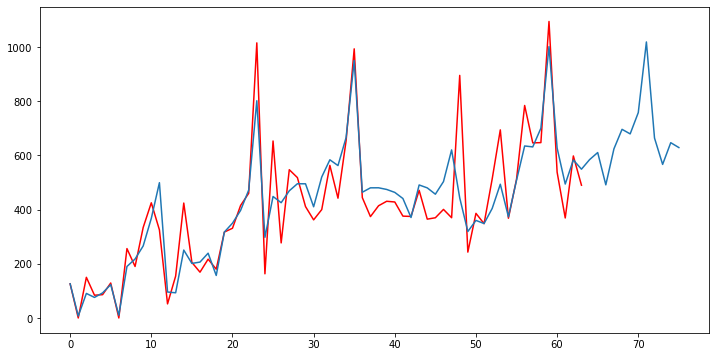

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(df[df.Wine_Denom == test_wine]['bottles'].values, "r")
plt.plot(history_forecast.loc[test_wine][:])

In [38]:
prediction.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.749027,1.85921,1.45268,0.775855,1.88837,1.99338,1.74018,0.182844,1.84979,1.51436,0.431023,1.17395
00100224 /,1.27243,1.47292,0.232958,0.00862501,1.33299,1.39895,1.40843,3.77404,0.69627,0.904347,2.23349,3.16576
00100324 /,1.52702,1.44211,1.4598,0.318217,0.825892,4.43737,1.30561,1.22577,0.977473,1.0261,1.59003,2.78736
00100424 /,0.465391,1.70405,2.10151,1.29915,1.09977,0.811706,1.17885,1.16941,0.247744,0.759695,0.18755,2.34707
00100524 /,5.91646,5.0399,6.42323,7.73939,7.02365,7.81926,5.45838,7.59118,5.32479,7.97793,6.32602,6.26189


In [39]:
prediction.to_csv('prediction.csv', encoding='utf-8', sep = ';')

### 7. Добавляем информацию о стоках

In [40]:
inventory = pd.read_csv("inventory.csv", encoding = 'latin', sep = ';')

In [41]:
inventory.head()

,Denom,Girteka,Moscow,Pade,Unpade,Truck,avg_prices,avg_cost
0,00100114 /,0,0,0,0,0,32.6,16.30
1,00100224 /,0,39,0,0,0,128.4,64.20
2,00100324 /,0,133,0,0,0,84.8,42.40
3,00100424 /,0,118,0,0,0,75.3,37.65
4,00100524 /,0,80,0,0,0,78.9,39.45


In [42]:
inventory = inventory.set_index('Denom')

In [43]:
inventory.head()

,Girteka,Moscow,Pade,Unpade,Truck,avg_prices,avg_cost
Denom,,,,,,,
00100114 /,0,0,0,0,0,32.6,16.30
00100224 /,0,39,0,0,0,128.4,64.20
00100324 /,0,133,0,0,0,84.8,42.40
00100424 /,0,118,0,0,0,75.3,37.65
00100524 /,0,80,0,0,0,78.9,39.45


In [44]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2666 entries, 00100114 / to 90600214 /
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Girteka     2666 non-null   int64  
 1   Moscow      2666 non-null   int64  
 2   Pade        2666 non-null   int64  
 3   Unpade      2666 non-null   int64  
 4   Truck       2666 non-null   int64  
 5   avg_prices  2666 non-null   float64
 6   avg_cost    2666 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 166.6+ KB


### 8. Строим алгоритм расчета заказа исходя из прогноза продаж

In [45]:
import random

#### подготовительные таблицы:

In [46]:
#create and calculate future stock data

#stock
stock = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
girteka = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
truck = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
pade = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
unpade = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)

stock.fillna(random.random(), inplace = True)
girteka.fillna(random.random(), inplace = True)
truck.fillna(random.random(), inplace = True)
pade.fillna(random.random(), inplace = True)
unpade.fillna(random.random(), inplace = True)

#covers
p_one = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
p_two = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
p_three = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
p_four = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)

p_one.fillna(random.random(), inplace = True)
p_two.fillna(random.random(), inplace = True)
p_three.fillna(random.random(), inplace = True)
p_four.fillna(random.random(), inplace = True)

#signals
signal_move = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
signal_order = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)

signal_move.fillna(random.random(), inplace = True)
signal_order.fillna(random.random(), inplace = True)

#actions
move = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
purchase = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)

move.fillna(random.random(), inplace = True)
purchase.fillna(random.random(), inplace = True)


#cover = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#signal = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
prices = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
revenue = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
expenses = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#price_increase_pct = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#discounts = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
cost_prices_eur = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#cost_increase_pct = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#profit = instead get expenses with minus sign
#margin = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)


#stock.fillna(0, inplace = True)
#purchase.fillna(0, inplace = True)
#cover.fillna(0, inplace = True)
#signal.fillna(0, inplace = True)
prices.fillna(random.random(), inplace = True)
revenue.fillna(random.random(), inplace = True)
expenses.fillna(random.random(), inplace = True)
#price_increase_pct.fillna(0, inplace = True)
#discounts.fillna(0, inplace = True)
cost_prices_eur.fillna(random.random(), inplace = True)
#cost_increase_pct.fillna(0, inplace = True)
#margin.fillna(0, inplace = True)

In [47]:
#create and calculate future stock data

#stock
stock = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
girteka = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
truck = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
pade = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
unpade = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)

stock.fillna(random.random(), inplace = True)
girteka.fillna(random.random(), inplace = True)
truck.fillna(random.random(), inplace = True)
pade.fillna(random.random(), inplace = True)
unpade.fillna(random.random(), inplace = True)

#covers
p_one = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
p_two = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
p_three = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
p_four = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)

p_one.fillna(random.random(), inplace = True)
p_two.fillna(random.random(), inplace = True)
p_three.fillna(random.random(), inplace = True)
p_four.fillna(random.random(), inplace = True)

#signals
signal_move = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
signal_order = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)

signal_move.fillna(random.random(), inplace = True)
signal_order.fillna(random.random(), inplace = True)

#actions
move = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
purchase = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)

move.fillna(random.random(), inplace = True)
purchase.fillna(random.random(), inplace = True)


#cover = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#signal = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
prices = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
revenue = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
expenses = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
#price_increase_pct = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#discounts = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
cost_prices_eur = pd.DataFrame(columns=prediction.iloc[:,:].columns, index=prediction.index)
#cost_increase_pct = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#profit = instead get expenses with minus sign
#margin = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)


#stock.fillna(0, inplace = True)
#purchase.fillna(0, inplace = True)
#cover.fillna(0, inplace = True)
#signal.fillna(0, inplace = True)
prices.fillna(random.random(), inplace = True)
revenue.fillna(random.random(), inplace = True)
expenses.fillna(random.random(), inplace = True)
#price_increase_pct.fillna(0, inplace = True)
#discounts.fillna(0, inplace = True)
cost_prices_eur.fillna(random.random(), inplace = True)
#cost_increase_pct.fillna(0, inplace = True)
#margin.fillna(0, inplace = True)

#### реализуем сам алгоритм через for loop:

In [38]:
# testing with producer 
num = 0
for i in prediction.index:
    num += 1
    for j in list(prediction.iloc[:,:-1].columns):

        optimal_coverage = 3
        optimal_p_four = optimal_coverage + 1
        optimal_p_three = optimal_coverage + 3
        
        try:
        
            if j == 0:

                signal_move.loc[i][j] = 1 if ((inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck']) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_four])) < optimal_p_four else 0
                move.loc[i][j] = sum(prediction.loc[i][j+1:j+1+optimal_p_four]) if signal_move.loc[i][j] > 0 else 0
                
                current_stock = (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] + inventory.loc[i]['Girteka'] + inventory.loc[i]['Unpade'] + inventory.loc[i]['Pade'])
                    
                signal_order.loc[i][j] = 1 if ((current_stock / np.mean(prediction.loc[i][j+1:j+1+optimal_coverage])) < optimal_p_three) and (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0) else 0
                purchase.loc[i][j] = 24 * round(sum(prediction.loc[i][j:j+optimal_p_three])/24) if signal_order.loc[i][j] > 0 else 0
                
                unpade.loc[i][j] = purchase.loc[i][j]
                pade.loc[i][j] = inventory.loc[i]['Unpade']
                
                if signal_move.loc[i][j] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] < 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] > 0 and inventory.loc[i]['Girteka'] > move.loc[i][j] - inventory.loc[i]['Truck']:
                    truck.loc[i][j] = move.loc[i][j]
                else:
                    truck.loc[i][j] = inventory.loc[i]['Girteka']
            
                girteka.loc[i][j] = inventory.loc[i]['Girteka'] + inventory.loc[i]['Pade'] - truck.loc[i][j]
                stock.loc[i][j] = 0 if (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] - prediction.loc[i][j]) < 0 else (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] - prediction.loc[i][j])
                prediction.loc[i][j] = inventory.loc[i]['Moscow'] if prediction.loc[i][j] > inventory.loc[i]['Moscow'] else prediction.loc[i][j]
            
                p_one.loc[i][j] = (stock.loc[i][j]) / (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three])) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_two.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_three.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j] + unpade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_four.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else (optimal_p_four + 1) #look in future
            
                prices.loc[i][j] = inventory.loc[i]['avg_prices']
                cost_prices_eur.loc[i][j] = inventory.loc[i]['avg_cost']
        
            else:
                
                signal_move.loc[i][j] = 1 if (p_four.loc[i][j-1] < optimal_p_four) else 0
                move.loc[i][j] = sum(prediction.loc[i][j+1:j+1+optimal_p_four]) if signal_move.loc[i][j] > 0 else 0
                
                #signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                
                try:
                    if (signal_order.loc[i][j-1] == 1) or (signal_order.loc[i][j-2] == 1) or (signal_order.loc[i][j-3] == 1):
                        signal_order.loc[i][j] = 0
                    else:
                        signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                except:
                    signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                
                purchase.loc[i][j] = 24 * round(sum(prediction.loc[i][j:j+optimal_p_three])/24) if signal_order.loc[i][j] > 0 else 0
                
                unpade.loc[i][j] = purchase.loc[i][j].tolist()
                pade.loc[i][j] = unpade.loc[i][j-1]
            
                if signal_move.loc[i][j] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - truck.loc[i][j-1] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - truck.loc[i][j-1] < 0:
                    truck.loc[i][j] = 0
                elif (move.loc[i][j] - truck.loc[i][j-1] > 0) and girteka.loc[i][j] > (move.loc[i][j] - truck.loc[i][j-1]):
                    truck.loc[i][j] = move.loc[i][j]
                else:
                    truck.loc[i][j] = girteka.loc[i][j-1]
            
            
                girteka.loc[i][j] = girteka.loc[i][j-1] + pade.loc[i][j-1] - truck.loc[i][j]
                stock.loc[i][j] = 0 if (stock.loc[i][j-1] + truck.loc[i][j-1] - prediction.loc[i][j]) < 0 else (stock.loc[i][j-1] + truck.loc[i][j-1] - prediction.loc[i][j])
                prediction.loc[i][j] = stock.loc[i][j-1] if prediction.loc[i][j] > stock.loc[i][j-1] else prediction.loc[i][j]  
            
                p_one.loc[i][j] = (stock.loc[i][j]) / (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three])) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_two.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_three.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j] + unpade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_four.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else (optimal_p_four + 1) #look in future 
            
                prices.loc[i][j] = inventory.loc[i]['avg_prices']
                cost_prices_eur.loc[i][j] = inventory.loc[i]['avg_cost']
        except:
            next

#### усовершенствование модели

In [48]:
# testing with producer 
num = 0
for i in prediction.index:
    num += 1
    for j in list(prediction.iloc[:,:].columns): #### изменение тут !! убрал -1

        optimal_coverage = 3
        optimal_p_four = optimal_coverage + 1
        optimal_p_three = optimal_coverage + 3
        
        try:
        
            if j == 0:

                signal_move.loc[i][j] = 1 if ((inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck']) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_four])) < optimal_p_four else 0
                move.loc[i][j] = sum(prediction.loc[i][j+1:j+1+optimal_p_four]) if signal_move.loc[i][j] > 0 else 0
                
                current_stock = (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] + inventory.loc[i]['Girteka'] + inventory.loc[i]['Pade'])
                
                signal_order.loc[i][j] = 1 if ((current_stock / np.mean(prediction.loc[i][j+1:j+1+optimal_coverage])) < optimal_p_three) and (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0) else 0
                purchase.loc[i][j] = 24 * round(sum(prediction.loc[i][j:j+optimal_p_three])/24) if signal_order.loc[i][j] > 0 else 0
                
                unpade.loc[i][j] = purchase.loc[i][j]
                pade.loc[i][j] = inventory.loc[i]['Pade'] ### ИЗМЕНЕНИЕ ЗДЕСЬ !!!
                
                if signal_move.loc[i][j] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] < 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] > 0 and inventory.loc[i]['Girteka'] > move.loc[i][j] - inventory.loc[i]['Truck']:
                    truck.loc[i][j] = move.loc[i][j]
                else:
                    truck.loc[i][j] = inventory.loc[i]['Girteka']
            
                girteka.loc[i][j] = inventory.loc[i]['Girteka'] - truck.loc[i][j]
                stock.loc[i][j] = 0 if (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] - prediction.loc[i][j]) < 0 else (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] - prediction.loc[i][j])
                prediction.loc[i][j] = inventory.loc[i]['Moscow'] if prediction.loc[i][j] > inventory.loc[i]['Moscow'] else prediction.loc[i][j]
            
                p_one.loc[i][j] = (stock.loc[i][j]) / (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three])) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_two.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_three.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j] + unpade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_four.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else (optimal_p_four + 1) #look in future
            
                prices.loc[i][j] = inventory.loc[i]['avg_prices']
                cost_prices_eur.loc[i][j] = inventory.loc[i]['avg_cost']
        
            else:
                
                signal_move.loc[i][j] = 1 if (p_four.loc[i][j-1] < optimal_p_four) else 0
                move.loc[i][j] = sum(prediction.loc[i][j+1:j+1+optimal_p_four]) if signal_move.loc[i][j] > 0 else 0
                
                #signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                
                try:
                    if (signal_order.loc[i][j-1] == 1) or (signal_order.loc[i][j-2] == 1) or (signal_order.loc[i][j-3] == 1):
                        signal_order.loc[i][j] = 0
                    else:
                        signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                except:
                    signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                
                purchase.loc[i][j] = 24 * round(sum(prediction.loc[i][j:j+optimal_p_three])/24) if signal_order.loc[i][j] > 0 else 0
                
                unpade.loc[i][j] = purchase.loc[i][j].tolist()
                pade.loc[i][j] = unpade.loc[i][j-1]
            
                if signal_move.loc[i][j] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - truck.loc[i][j-1] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - truck.loc[i][j-1] < 0:
                    truck.loc[i][j] = 0
                elif (move.loc[i][j] - truck.loc[i][j-1] > 0) and girteka.loc[i][j] > (move.loc[i][j] - truck.loc[i][j-1]):
                    truck.loc[i][j] = move.loc[i][j]
                else:
                    truck.loc[i][j] = girteka.loc[i][j-1]
            
            
                girteka.loc[i][j] = girteka.loc[i][j-1] + pade.loc[i][j-1] - truck.loc[i][j]
                stock.loc[i][j] = 0 if (stock.loc[i][j-1] + truck.loc[i][j-1] - prediction.loc[i][j]) < 0 else (stock.loc[i][j-1] + truck.loc[i][j-1] - prediction.loc[i][j])
                prediction.loc[i][j] = stock.loc[i][j-1] if prediction.loc[i][j] > stock.loc[i][j-1] else prediction.loc[i][j]  
            
                p_one.loc[i][j] = (stock.loc[i][j]) / (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three])) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_two.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_three.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j] + unpade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_four.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else (optimal_p_four + 1) #look in future 
            
                prices.loc[i][j] = inventory.loc[i]['avg_prices']
                cost_prices_eur.loc[i][j] = inventory.loc[i]['avg_cost']
        except:
            next

#### снижаем правило до 3-х месяцев

In [103]:
# testing with producer 
num = 0
for i in prediction.index:
    num += 1
    for j in list(prediction.iloc[:,:-1].columns):

        optimal_coverage = 3
        optimal_p_four = optimal_coverage + 1
        optimal_p_three = optimal_coverage + 3
        
        try:
        
            if j == 0:

                signal_move.loc[i][j] = 1 if ((inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck']) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_four])) < optimal_p_four else 0
                move.loc[i][j] = sum(prediction.loc[i][j+1:j+1+optimal_p_four]) if signal_move.loc[i][j] > 0 else 0
                
                current_stock = (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] + inventory.loc[i]['Girteka'] + inventory.loc[i]['Pade'])
                    
                signal_order.loc[i][j] = 1 if ((current_stock / np.mean(prediction.loc[i][j+1:j+1+optimal_coverage])) < optimal_p_three) and (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0) else 0
                purchase.loc[i][j] = 24 * round(sum(prediction.loc[i][j:j+optimal_p_three])/24) if signal_order.loc[i][j] > 0 else 0
                
                unpade.loc[i][j] = purchase.loc[i][j]
                pade.loc[i][j] = inventory.loc[i]['Pade'] ### ИЗМЕНЕНИЕ ЗДЕСЬ !!!
                
                if signal_move.loc[i][j] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] < 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] > 0 and inventory.loc[i]['Girteka'] > move.loc[i][j] - inventory.loc[i]['Truck']:
                    truck.loc[i][j] = move.loc[i][j]
                else:
                    truck.loc[i][j] = inventory.loc[i]['Girteka']
            
                girteka.loc[i][j] = inventory.loc[i]['Girteka'] - truck.loc[i][j]
                stock.loc[i][j] = 0 if (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] - prediction.loc[i][j]) < 0 else (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] - prediction.loc[i][j])
                prediction.loc[i][j] = inventory.loc[i]['Moscow'] if prediction.loc[i][j] > inventory.loc[i]['Moscow'] else prediction.loc[i][j]
            
                p_one.loc[i][j] = (stock.loc[i][j]) / (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three])) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_two.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_three.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j] + unpade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_four.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else (optimal_p_four + 1) #look in future
            
                prices.loc[i][j] = inventory.loc[i]['avg_prices']
                cost_prices_eur.loc[i][j] = inventory.loc[i]['avg_cost']
        
            else:
                
                signal_move.loc[i][j] = 1 if (p_four.loc[i][j-1] < optimal_p_four) else 0
                move.loc[i][j] = sum(prediction.loc[i][j+1:j+1+optimal_p_four]) if signal_move.loc[i][j] > 0 else 0
                
                #signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                
                try:
                    if (signal_order.loc[i][j-1] == 1) or (signal_order.loc[i][j-2] == 1) or (signal_order.loc[i][j-3] == 1):
                        signal_order.loc[i][j] = 0
                    else:
                        signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                except:
                    signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                
                purchase.loc[i][j] = 24 * round(sum(prediction.loc[i][j:j+optimal_p_three])/24) if signal_order.loc[i][j] > 0 else 0
                
                unpade.loc[i][j] = purchase.loc[i][j].tolist()
                pade.loc[i][j] = unpade.loc[i][j-1]
            
                if signal_move.loc[i][j] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - truck.loc[i][j-1] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - truck.loc[i][j-1] < 0:
                    truck.loc[i][j] = 0
                elif (move.loc[i][j] - truck.loc[i][j-1] > 0) and girteka.loc[i][j] > (move.loc[i][j] - truck.loc[i][j-1]):
                    truck.loc[i][j] = move.loc[i][j]
                else:
                    truck.loc[i][j] = girteka.loc[i][j-1]
            
            
                girteka.loc[i][j] = girteka.loc[i][j-1] + pade.loc[i][j-1] - truck.loc[i][j]
                stock.loc[i][j] = 0 if (stock.loc[i][j-1] + truck.loc[i][j-1] - prediction.loc[i][j]) < 0 else (stock.loc[i][j-1] + truck.loc[i][j-1] - prediction.loc[i][j])
                prediction.loc[i][j] = stock.loc[i][j-1] if prediction.loc[i][j] > stock.loc[i][j-1] else prediction.loc[i][j]  
            
                p_one.loc[i][j] = (stock.loc[i][j]) / (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three])) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_two.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_three.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j] + unpade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_four.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else (optimal_p_four + 1) #look in future 
            
                prices.loc[i][j] = inventory.loc[i]['avg_prices']
                cost_prices_eur.loc[i][j] = inventory.loc[i]['avg_cost']
        except:
            next

#### Проверяем интуитивно правильность работы на базе тестового вина

test names:

1. 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75
2. 02800224 / EL CASTRO DE VALTUILLE MENCIA JOVEN / Red / 0,75
3. 16000414 / SAAR RIESLING / White / 0,75
4. 16000614 / SCHIEFER RIESLING / White / 0,75
5. 00200114 / ALVARINHO MUROS ANTIGOS VINHO VERDE / White / 0,75

In [49]:
test_wine = '16000114 /'

In [50]:
inventory.loc[test_wine]

Girteka         0.00
Moscow        238.00
Pade            0.00
Unpade          0.00
Truck           0.00
avg_prices     19.88
avg_cost        9.94
Name: 16000114 /, dtype: float64

In [51]:
signal_order.loc[test_wine]

0     1.0
1     0.0
2     0.0
3     0.0
4     1.0
5     0.0
6     0.0
7     0.0
8     0.0
9     1.0
10    0.0
11    0.0
Name: 16000114 /, dtype: float64

In [52]:
inventory.loc[test_wine]

Girteka         0.00
Moscow        238.00
Pade            0.00
Unpade          0.00
Truck           0.00
avg_prices     19.88
avg_cost        9.94
Name: 16000114 /, dtype: float64

In [53]:
stock.loc[test_wine]

0     144.641103
1      36.957607
2       0.000000
3       0.000000
4     484.864666
5     388.571982
6     277.726044
7     153.421469
8     699.114415
9     580.146005
10    435.812061
11    296.115128
Name: 16000114 /, dtype: float64

In [54]:
signal_move.loc[test_wine]

0     1.0
1     1.0
2     1.0
3     1.0
4     0.0
5     0.0
6     1.0
7     1.0
8     0.0
9     0.0
10    0.0
11    1.0
Name: 16000114 /, dtype: float64

In [55]:
prices.loc[test_wine]

0     19.88
1     19.88
2     19.88
3     19.88
4     19.88
5     19.88
6     19.88
7     19.88
8     19.88
9     19.88
10    19.88
11    19.88
Name: 16000114 /, dtype: float64

In [56]:
cost_prices_eur.loc[test_wine]

0     9.94
1     9.94
2     9.94
3     9.94
4     9.94
5     9.94
6     9.94
7     9.94
8     9.94
9     9.94
10    9.94
11    9.94
Name: 16000114 /, dtype: float64

In [57]:
girteka.loc[test_wine]

0       0.0
1       0.0
2     576.0
3       0.0
4       0.0
5       0.0
6     648.0
7       0.0
8       0.0
9       0.0
10      0.0
11    408.0
Name: 16000114 /, dtype: float64

In [58]:
truck.loc[test_wine]

0       0.0
1       0.0
2       0.0
3     576.0
4       0.0
5       0.0
6       0.0
7     648.0
8       0.0
9       0.0
10      0.0
11      0.0
Name: 16000114 /, dtype: float64

In [59]:
purchase.loc[test_wine]

0     576.0
1       0.0
2       0.0
3       0.0
4     648.0
5       0.0
6       0.0
7       0.0
8       0.0
9     408.0
10      0.0
11      0.0
Name: 16000114 /, dtype: float64

In [60]:
pade.loc[test_wine]

0       0.0
1     576.0
2       0.0
3       0.0
4       0.0
5     648.0
6       0.0
7       0.0
8       0.0
9       0.0
10    408.0
11      0.0
Name: 16000114 /, dtype: float64

In [61]:
p_one.loc[test_wine]

0     1.442283
1     0.358615
2     0.000000
3     0.000000
4     4.173556
5     3.148640
6     2.205537
7     1.214483
8     5.204335
9     4.085091
10    3.119697
11    0.000000
Name: 16000114 /, dtype: float64

In [62]:
p_two.loc[test_wine]

0     1.442283
1     5.947788
2     5.550100
3     5.367677
4     4.173556
5     8.399452
6     7.351572
7     6.344044
8     5.204335
9     4.085091
10    6.040305
11    0.000000
Name: 16000114 /, dtype: float64

In [63]:
p_three.loc[test_wine]

0     7.185843
1     5.947788
2     5.550100
3     5.367677
4     9.751327
5     8.399452
6     7.351572
7     6.344044
8     5.204335
9     6.958018
10    6.040305
11    0.000000
Name: 16000114 /, dtype: float64

In [64]:
p_four.loc[test_wine]

0     1.442283
1     0.358615
2     0.000000
3     5.367677
4     4.173556
5     3.148640
6     2.205537
7     6.344044
8     5.204335
9     4.085091
10    3.119697
11    5.000000
Name: 16000114 /, dtype: float64

In [65]:
unpade.loc[test_wine]

0     576.0
1       0.0
2       0.0
3       0.0
4     648.0
5       0.0
6       0.0
7       0.0
8       0.0
9     408.0
10      0.0
11      0.0
Name: 16000114 /, dtype: float64

In [66]:
prediction.loc[test_wine]

0     93.3589
1     107.683
2     36.9576
3           0
4           0
5     96.2927
6     110.846
7     124.305
8     102.307
9     118.968
10    144.334
11    139.697
Name: 16000114 /, dtype: object

### 8. Добавляем также информацию о курсе евро для расчета выручки и расходов

In [67]:
#currency date: 26.03.2021

forward_12m_eurrub = [89.6760, 90.0656, 90.5028, 90.9294, 91.3843, 91.8109, 
                      92.3000, 92.8000, 93.1746, 93.6000, 94.0000, 94.6388]

spot_rate = forward_12m_eurrub

hedging_eurrub = [79.14, 86.26, 0, 80.60, 0, 0,
                  82.05, 0, 0, 83.56, 0, 0]
                  
hedging_cost = [0.05, 0.05, 0, 0.05, 0, 0,
                0.05, 0, 0, 0.05, 0, 0]
                
hedging_sum = [252726, 579630, 0, 248133, 0, 0,
               243763, 0, 0, 239343, 0, 0]

In [68]:
hedging_result = ((list((np.array(forward_12m_eurrub) - np.array(hedging_eurrub)) * np.array(hedging_sum) / np.array(forward_12m_eurrub))))
hedging_cost_eur = list(-np.array(hedging_cost) * np.array(hedging_sum))
hedging_profit = list(np.array(hedging_result) + np.array(hedging_cost_eur))

In [69]:
hedging = pd.DataFrame(hedging_profit)
hedging = hedging.rename(columns = {0: 'hedging'})
hedging = np.transpose(hedging)
hedging

,0,1,2,3,4,5,6,7,8,9,10,11
hedging,17056.384063,-4490.019035,0.0,15780.768043,0.0,0.0,14881.955634,0.0,0.0,13705.966667,0.0,0.0


In [70]:
receivables = [0.66, 0.33]

for i in prediction.index:
    for j in list(prediction.iloc[:,:-1].columns):
        if j == 0:
            revenue.loc[i][0] = (prices.loc[i][j] * prediction.loc[i][j] * receivables[0]) / forward_12m_eurrub[0]
        else:
            revenue.loc[i][j] = (prices.loc[i][j] * prediction.loc[i][j] * receivables[0] + prices.loc[i][j] * prediction.loc[i][j-1] * receivables[1]) / forward_12m_eurrub[11] 

In [71]:
for i in prediction.index:
    for j in list(prediction.iloc[:,:-1].columns):
        expenses.loc[i][j] = (purchase.loc[i][j] * cost_prices_eur.loc[i][j])

In [72]:
cost_prices_eur.loc['13401114 /']

0     1.7313
1     1.7313
2     1.7313
3     1.7313
4     1.7313
5     1.7313
6     1.7313
7     1.7313
8     1.7313
9     1.7313
10    1.7313
11    1.7313
Name: 13401114 /, dtype: float64

In [73]:
purchase.loc['13401114 /']

0     120.0
1       0.0
2       0.0
3       0.0
4       0.0
5      96.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
Name: 13401114 /, dtype: float64

### 9. Смотрим результаты:

In [74]:
prediction.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0,0,0,0,0,0,0,0,0,0,0,0
00100224 /,1.27243,1.47292,0.232958,0.00862501,1.33299,1.39895,1.40843,3.77404,0.69627,0.904347,2.23349,3.16576
00100324 /,1.52702,1.44211,1.4598,0.318217,0.825892,4.43737,1.30561,1.22577,0.977473,1.0261,1.59003,2.78736
00100424 /,0.465391,1.70405,2.10151,1.29915,1.09977,0.811706,1.17885,1.16941,0.247744,0.759695,0.18755,2.34707
00100524 /,5.91646,5.0399,6.42323,7.73939,7.02365,7.81926,5.45838,7.59118,5.32479,7.97793,6.32602,6.26189


In [75]:
stock.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
00100224 /,37.727568,36.254644,36.021686,36.013061,34.680074,33.281122,31.872694,28.098650,27.402381,26.498033,24.264542,21.098778
00100324 /,131.472981,130.030867,128.571066,128.252849,127.426957,122.989590,121.683983,120.458217,119.480744,118.454646,116.864614,114.077258
00100424 /,117.534609,115.830560,113.729051,112.429898,111.330129,110.518423,109.339571,108.170159,107.922415,107.162721,106.975170,104.628100
00100524 /,74.083537,69.043639,62.620405,54.881018,47.857364,40.038107,34.579726,26.988545,21.663755,13.685830,7.359809,25.097923


In [76]:
girteka.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100224 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100324 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100424 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100524 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0


In [77]:
truck.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100224 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100324 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100424 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100524 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0


In [78]:
pade.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100224 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100324 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100424 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100524 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0


In [79]:
unpade.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100224 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100324 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100424 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100524 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0


In [80]:
signal_move.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00100224 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100324 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100424 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100524 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [81]:
signal_order.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
00100224 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100324 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100424 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100524 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [82]:
purchase.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100224 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100324 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100424 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00100524 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0


In [83]:
p_one.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
00100224 /,38.662727,26.670921,25.075120,22.709168,19.977898,16.391487,14.791601,16.056664,13.041294,9.815440,7.664671,0.0
00100324 /,80.584127,81.501488,84.862387,78.536554,72.385616,82.799600,79.984479,75.511040,66.335367,54.121155,41.926696,0.0
00100424 /,86.053004,90.724152,117.516299,128.072280,153.383959,112.576261,116.035485,122.155105,98.280576,84.559170,45.578166,0.0
00100524 /,11.252110,9.850456,9.173661,7.993315,7.090408,6.169171,5.163958,4.169625,3.160157,2.174441,1.175334,0.0


In [84]:
p_two.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
00100224 /,38.662727,26.670921,25.075120,22.709168,19.977898,16.391487,14.791601,16.056664,13.041294,9.815440,7.664671,0.0
00100324 /,80.584127,81.501488,84.862387,78.536554,72.385616,82.799600,79.984479,75.511040,66.335367,54.121155,41.926696,0.0
00100424 /,86.053004,90.724152,117.516299,128.072280,153.383959,112.576261,116.035485,122.155105,98.280576,84.559170,45.578166,0.0
00100524 /,11.252110,9.850456,9.173661,7.993315,7.090408,6.169171,5.163958,4.169625,6.661110,5.987625,5.008046,0.0


In [85]:
p_three.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
00100224 /,38.662727,26.670921,25.075120,22.709168,19.977898,16.391487,14.791601,16.056664,13.041294,9.815440,7.664671,0.0
00100324 /,80.584127,81.501488,84.862387,78.536554,72.385616,82.799600,79.984479,75.511040,66.335367,54.121155,41.926696,0.0
00100424 /,86.053004,90.724152,117.516299,128.072280,153.383959,112.576261,116.035485,122.155105,98.280576,84.559170,45.578166,0.0
00100524 /,11.252110,9.850456,9.173661,7.993315,7.090408,6.169171,5.163958,7.877531,6.661110,5.987625,5.008046,0.0


In [86]:
p_four.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.0
00100224 /,38.662727,26.670921,25.075120,22.709168,19.977898,16.391487,14.791601,16.056664,13.041294,9.815440,7.664671,5.0
00100324 /,80.584127,81.501488,84.862387,78.536554,72.385616,82.799600,79.984479,75.511040,66.335367,54.121155,41.926696,5.0
00100424 /,86.053004,90.724152,117.516299,128.072280,153.383959,112.576261,116.035485,122.155105,98.280576,84.559170,45.578166,5.0
00100524 /,11.252110,9.850456,9.173661,7.993315,7.090408,6.169171,5.163958,4.169625,3.160157,2.174441,5.008046,5.0


In [87]:
prices.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,32.6,32.6,32.6,32.6,32.6,32.6,32.6,32.6,32.6,32.6,32.6,32.6
00100224 /,128.4,128.4,128.4,128.4,128.4,128.4,128.4,128.4,128.4,128.4,128.4,128.4
00100324 /,84.8,84.8,84.8,84.8,84.8,84.8,84.8,84.8,84.8,84.8,84.8,84.8
00100424 /,75.3,75.3,75.3,75.3,75.3,75.3,75.3,75.3,75.3,75.3,75.3,75.3
00100524 /,78.9,78.9,78.9,78.9,78.9,78.9,78.9,78.9,78.9,78.9,78.9,78.9


In [88]:
revenue.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.374719
00100224 /,1.202451,1.888623,0.868064,0.112024,1.197481,1.849497,1.887516,4.010041,2.313200,1.121531,2.404870,0.374719
00100324 /,0.953033,1.304373,1.289728,0.619841,0.582515,2.868404,2.084214,1.110958,0.940513,0.895851,1.243732,0.374719
00100424 /,0.257917,1.017049,1.550999,1.234015,0.918640,0.715017,0.832181,0.923625,0.437147,0.463990,0.297960,0.374719
00100524 /,3.435634,4.400886,4.920892,6.025674,5.993949,6.234809,5.154649,5.678675,5.018393,5.854724,5.675711,0.374719


In [89]:
expenses.head()

,0,1,2,3,4,5,6,7,8,9,10,11
00100114 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464319
00100224 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464319
00100324 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464319
00100424 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464319
00100524 /,0.0,0.0,0.0,0.0,0.0,0.0,0.0,946.8,0.0,0.0,0.0,0.464319


### 10. Просто транспонируем таблицу для последующей визуализации в Tableau:

In [90]:
tableau_forecast = pd.DataFrame()

In [91]:
test = df[df.Wine_Denom == '00100114 /']

date_bottles = test[['date','bottles']]
date_bottles = date_bottles.rename(columns={'date':'ds', 'bottles':'y'})

In [92]:
date_bottles

,ds,y
0,2017-01-01,1
2666,2017-02-01,9
5332,2017-03-01,1
7998,2017-04-01,12
10664,2017-05-01,9
...,...,...
157294,2021-12-01,0
159960,2022-01-01,2.15021
162626,2022-02-01,1.57527
165292,2022-03-01,-0.14094


In [93]:
import datetime

In [94]:
future_dates = date_bottles[-12:]['ds'] + datetime.timedelta(days=365) + datetime.timedelta(days=1)

In [95]:
for i in prediction.index:
    try:
        wine_producer = [i,]*12
        future_bottles = list(prediction.loc[i])[:]
        future_dates = list(future_dates)
    
        purchase_order = list(signal_order.loc[i])
    
        stock_moscow = list(stock.loc[i])
        stock_girteka = list(girteka.loc[i])
        stock_truck = list(truck.loc[i])
        stock_pade = list(pade.loc[i])
        stock_unpade = list(unpade.loc[i])
    
        p_one_num = list(p_one.loc[i])
        p_two_num = list(p_two.loc[i])
        p_three_num = list(p_three.loc[i])
        p_four_num = list(p_four.loc[i])
    
        revenue_sum = list(revenue.loc[i])
        expenses_sum = list(expenses.loc[i])
    
        lists = [wine_producer, future_bottles, future_dates, purchase_order,
             stock_moscow, stock_girteka, stock_truck, stock_pade, stock_unpade,
            p_one_num, p_two_num, p_three_num, p_four_num,
            revenue_sum, expenses_sum]
        future_data = pd.concat([pd.Series(x) for x in lists], axis = 1)
    
        tableau_forecast = tableau_forecast.append(future_data)
        
    except:
        next

In [96]:
tableau_forecast

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,00100114 /,0.000000,2022-05-02,1.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,00100114 /,0.000000,2022-06-02,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,00100114 /,0.000000,2022-07-02,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,00100114 /,0.000000,2022-08-02,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,00100114 /,0.000000,2022-09-02,1.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,90600214 /,0.000650,2022-12-02,0.0,0.005025,-0.026426,0.00782,0.0,0.0,2.570326,-6.945883,-6.945883,6.570326,0.000000,0.000000
8,90600214 /,0.003788,2023-01-02,1.0,0.009058,-0.026426,0.00000,0.0,0.0,6.738703,-12.921483,-12.921483,6.738703,0.000000,0.000000
9,90600214 /,0.000596,2023-02-02,0.0,0.008462,-0.026426,0.00000,0.0,0.0,4.924548,-10.454357,-10.454357,4.924548,0.000000,0.000000
10,90600214 /,0.001122,2023-03-02,0.0,0.007340,-0.026426,0.00000,0.0,0.0,3.171370,-8.246904,-8.246904,3.171370,0.000000,0.000000


In [97]:
tableau_forecast.to_csv('tableau_forecast.csv', sep = ';')

In [116]:
df.to_csv('history.csv', sep = ';')